In [5]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [6]:
def get_data():
    from sklearn.impute import SimpleImputer
    cervical_cancer_risk_factors = fetch_ucirepo(id=383)
    df = cervical_cancer_risk_factors.data.features
    df = df.dropna(thresh=len(df)*0.5, axis=1)
    # Remplacer les valeurs manquantes restantes par des médianes pour les colonnes numériques
    imputer = SimpleImputer(strategy="median")
    df.iloc[:, :] = imputer.fit_transform(df)
    return df

In [7]:
def get_data_origninal():
    df=get_data()
    cols_to_drop = ["Smokes (years)", "Hormonal Contraceptives (years)", "IUD (years)", "STDs: Number of diagnosis", "Dx"]
    df= df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    return df


In [8]:
df=get_data_origninal()
print(df.shape)

(858, 29)


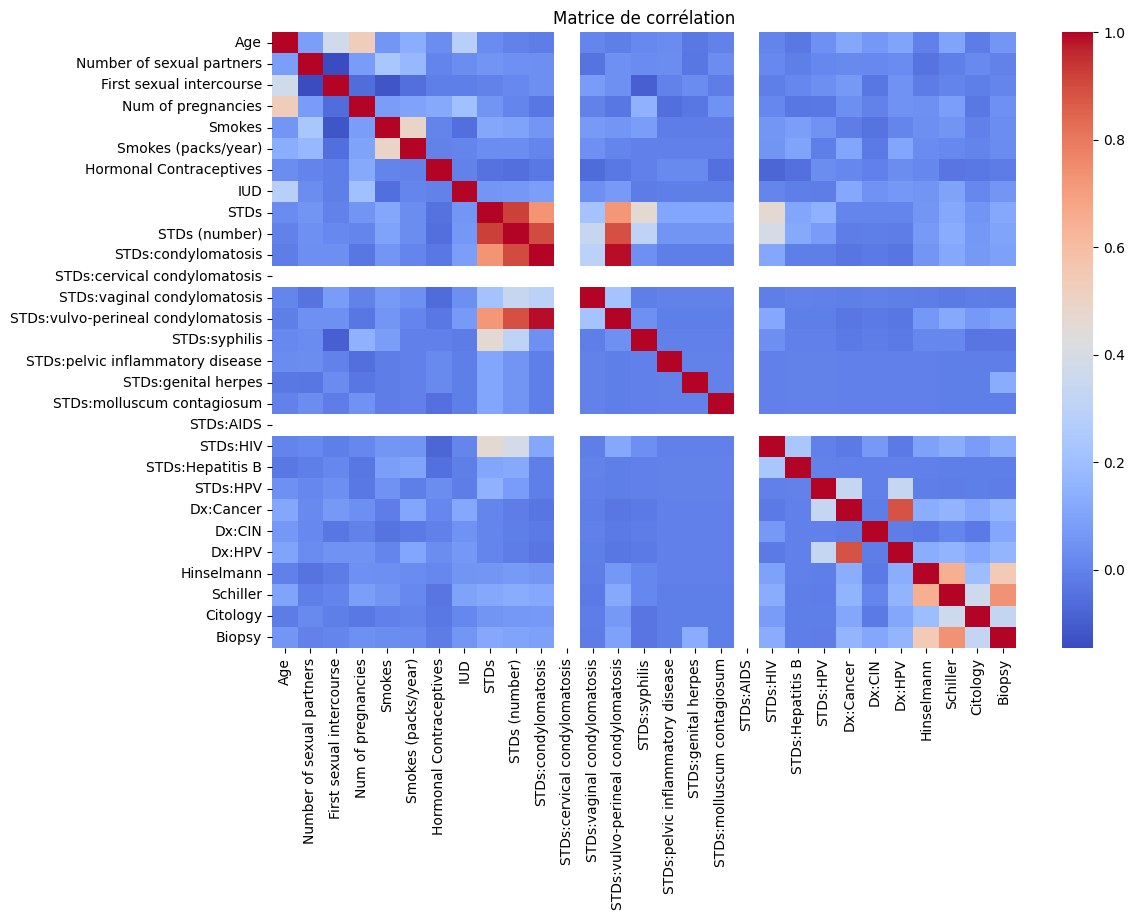

In [9]:
#Vérifier les corrélations et supprimer les colonnes redondantes
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

In [10]:
df.head()
# visualiser les colonnes

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (packs/year),Hormonal Contraceptives,IUD,STDs,STDs (number),...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Dx:Cancer,Dx:CIN,Dx:HPV,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,0,1,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [11]:
df.describe()
# pour avoir des statistiques

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (packs/year),Hormonal Contraceptives,IUD,STDs,STDs (number),...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Dx:Cancer,Dx:CIN,Dx:HPV,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.511655,16.995338,2.257576,0.143357,0.446278,0.686480,0.096737,0.092075,0.155012,...,0.020979,0.001166,0.002331,0.020979,0.010490,0.020979,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.644759,2.791883,1.400981,0.350641,2.210351,0.464194,0.295771,0.289300,0.529617,...,0.143398,0.034139,0.048252,0.143398,0.101939,0.143398,0.197925,0.280892,0.220701,0.245078
min,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df.isnull()
# pour avoir les colonnes manquantes

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (packs/year),Hormonal Contraceptives,IUD,STDs,STDs (number),...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,Dx:Cancer,Dx:CIN,Dx:HPV,Hinselmann,Schiller,Citology,Biopsy
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
854,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
855,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
856,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
#affin de visualiser le déséquilibre et ensuite équilibrer les données
df["Biopsy"].value_counts()

,count
Biopsy,
0,803
1,55


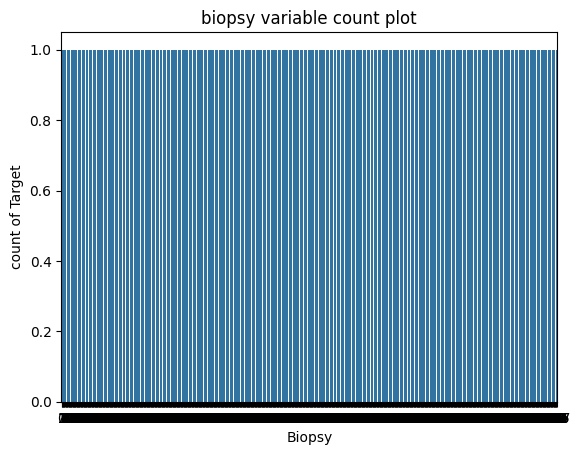

In [14]:
sns.countplot(df["Biopsy"])
plt.xlabel ("Biopsy")
plt.ylabel("count of Target")
plt.title("biopsy variable count plot")
plt.show()

In [15]:
# Séparation des caractéristiques (X) et de la cible (y)
print("\nÉtape 4 : Séparation des caractéristiques et de la cible...")
X = df.drop("Biopsy", axis=1)  # Remplacez "Biopsy" par le nom de votre colonne cible si différent
y = df["Biopsy"]
print(f"Caractéristiques (X) : {X.shape}")
print(f"Cible (y) : {y.shape}")


Étape 4 : Séparation des caractéristiques et de la cible...
Caractéristiques (X) : (858, 28)
Cible (y) : (858,)


In [16]:
class_ratio = (y == 0).sum() / (y == 1).sum()
print(f"Rapport des classes (majoritaire/minoritaire) : {class_ratio:.2f}")

Rapport des classes (majoritaire/minoritaire) : 14.60


In [17]:
# Encodage des variables catégorielles (si nécessaire)
print("\nÉtape 5 : Encodage des variables catégorielles...")
X = pd.get_dummies(X, drop_first=True)
print(f"Caractéristiques après encodage : {X.shape}")


Étape 5 : Encodage des variables catégorielles...
Caractéristiques après encodage : (858, 28)


In [18]:
# Division des données en ensembles d'entraînement et de test
print("\nÉtape 6 : Division des données en ensembles d'entraînement et de test...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Taille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")


Étape 6 : Division des données en ensembles d'entraînement et de test...
Taille de l'ensemble d'entraînement : (686, 28)
Taille de l'ensemble de test : (172, 28)


In [19]:
# Entraînement du modèle CatBoost
print("\nÉtape 6 : Entraînement du modèle CatBoost...")

# Identifier les colonnes catégorielles
cat_features = list(X.select_dtypes(include=['object']).columns)

# Initialiser et entraîner le modèle CatBoost
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    auto_class_weights='Balanced',  # Gestion du déséquilibre
    verbose=10
)
model.fit(X_train, y_train)
print("Modèle CatBoost entraîné.")


Étape 6 : Entraînement du modèle CatBoost...
0:	learn: 0.5611013	total: 48.5ms	remaining: 4.8s
10:	learn: 0.2171331	total: 61.9ms	remaining: 501ms
20:	learn: 0.1527735	total: 77.1ms	remaining: 290ms
30:	learn: 0.1242745	total: 91.5ms	remaining: 204ms
40:	learn: 0.0922587	total: 105ms	remaining: 150ms
50:	learn: 0.0783212	total: 116ms	remaining: 112ms
60:	learn: 0.0684859	total: 128ms	remaining: 82.1ms
70:	learn: 0.0543098	total: 146ms	remaining: 59.7ms
80:	learn: 0.0480590	total: 162ms	remaining: 38ms
90:	learn: 0.0426183	total: 177ms	remaining: 17.5ms
99:	learn: 0.0360373	total: 191ms	remaining: 0us
Modèle CatBoost entraîné.


In [20]:
# Prédictions et évaluation du modèle
print("\nÉtape 7 : Prédictions et évaluation du modèle...")
preds = model.predict(X_test)
predictions = [1 if value > 0.5 else 0 for value in preds]

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, preds)

print(f"Exactitude du modèle : {accuracy:.2f}")
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"Score F1 : {f1:.2f}")
print(f"ROC-AUC : {roc_auc:.2f}")

# Rapport de classification détaillé
print("\nÉtape 8 : Rapport de classification...")
print(classification_report(y_test, predictions))


Étape 7 : Prédictions et évaluation du modèle...
Exactitude du modèle : 0.95
Précision : 0.56
Rappel : 0.91
Score F1 : 0.69
ROC-AUC : 0.93

Étape 8 : Rapport de classification...
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       161
           1       0.56      0.91      0.69        11

    accuracy                           0.95       172
   macro avg       0.77      0.93      0.83       172
weighted avg       0.97      0.95      0.95       172




Étape 9 : Interprétation du modèle avec SHAP...


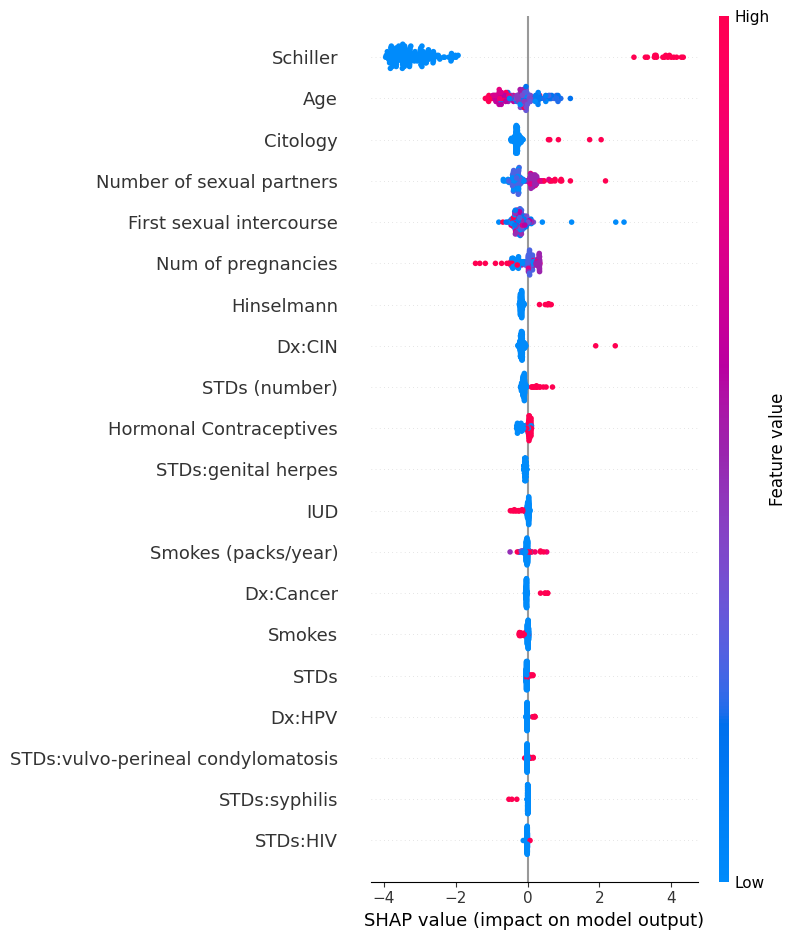

In [21]:
# Interprétation du modèle avec SHAP
print("\nÉtape 9 : Interprétation du modèle avec SHAP...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Graphique récapitulatif SHAP
shap.summary_plot(shap_values, X_test)